# Assignment

In [180]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [181]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [182]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT

    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 3 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 2 0]]
check?  0
dofk2  2

[[0 0 0 0]
 [0 3 0 1]
 [0 0 0 0]
 [2 0 0 0]]
0  0
check?  0
dofk2  1

[[0 3 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [2 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [0 3 0 1]
 [0 0 0 0]
 [2 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [0 0 0 1]
 [3 0 0 0]
 [0 0 0 2]]
0  0
check?  0
dofk2  2

[[0 0 0 0]
 [3 0 0 1]
 [0 0 2 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1


In [183]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a_base,_=np.where(allowed_a==1)
        
        a_agent_base=np.random.permutation(a_base)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent_base)
                
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.22 Number of steps:  6.997


## Importing, Initialize Parameters, Build Model and Save Load Model

In [184]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

import tensorflow as tf
from tensorflow import keras
from collections import deque

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 
max_T = 200 # maximum number of actions per episode


In [185]:
def build_model():
    #init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(200, input_shape=(np.shape(X)), activation='relu'))
    #model.add(keras.layers.Dense(200, activation='relu'))
    # change 32?
    model.add(keras.layers.Dense(32, activation='linear'))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [186]:
def load(model, name):
    model.load_weights(name)
    
def save(model, name):
    model.save_weights(name)

## Task 3: SARSA

**Saving Variables and Initializing the Game**

In [187]:
# SAVING VARIABLES
# initialize parameters
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
#memory = deque(maxlen=2000)
n_steps = 0

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE

Qtable = np.random.randn(1, N_a)/1000

R_Sarsa = np.zeros([N_episodes])
N_moves_Sarsa = np.zeros([N_episodes])

**Epsilon Greedy Policy Function for Q Values**

In [188]:
def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    allowed_ind,_=np.where(allowed_a==1)
    Qvalues_allowed = np.take(Qvalues, allowed_ind)
    
    rand_value=np.random.uniform(0,1)

    if rand_value<epsilon:
        a = np.random.choice(allowed_ind)
    else:
        a_q = np.argmax(Qvalues_allowed)
        a = allowed_ind[a_q] 
    return a

**Epsilon Greedy Policy Function for Model**

In [189]:
def greedy(model, X, epsilon, allowed_a):
    allowed_ind,_=np.where(allowed_a==1)

    rand_value=np.random.uniform(0,1)

    if rand_value < epsilon:
        a = np.random.choice(allowed_ind)
    else:
        import pdb;
        #pdb.set_trace();
        X_reshape = np.reshape(X, (1, N_in))
        predicted = model.predict(X_reshape)
        predicted_allowed = np.take(predicted, allowed_ind)
        a_p = np.argmax(predicted_allowed)
        a = allowed_ind[a_p]

    return a

**SARSA algorithm**

In [191]:
# SARSA

# SAVING VARIABLES
# initialize parameters
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

R_Sarsa = np.zeros([N_episodes])
N_moves_Sarsa = np.zeros([N_episodes])

model = build_model()

for n in range(N_episodes):

    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    
    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
    epsilon_f = epsilon_0
    a = greedy(model, X, epsilon_f, allowed_a)   #make an action
    
    for time in range(max_T):
        # take action a
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a)
        R_Sarsa[n] += np.copy(R)
        N_moves_Sarsa[n] = np.copy(time+1)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            print("episode: {}/{}, score: {}, reward average: {}"
                  .format(n, N_episodes,  N_moves_Sarsa[n], R_Sarsa[n-100:n].mean() if n > 100 else 0))
            break
            
        # chose a with epsilon greedy
        a_next = greedy(model, X_next, epsilon_f, allowed_a_next) #make an action
        
        target = R
        
        if Done == 0:
            target = (R + gamma * model.predict(np.array([X_next]))[0])[a_next]
        X_reshape = np.reshape(X, (1, N_in))
        target_f = model.predict(X_reshape)
        target_f[0][a] = target
        model.fit(X_reshape, target_f, epochs=1, verbose=0)
        
        X = X_next
        allowed_a = allowed_a_next
        a = a_next
        epsilon_f = epsilon_f/ (1 + beta * e)


episode: 0/100000, score: 27.0, reward average: 0
episode: 1/100000, score: 1.0, reward average: 0
episode: 2/100000, score: 1.0, reward average: 0
episode: 3/100000, score: 8.0, reward average: 0
episode: 4/100000, score: 1.0, reward average: 0
episode: 5/100000, score: 17.0, reward average: 0
episode: 6/100000, score: 9.0, reward average: 0
episode: 7/100000, score: 7.0, reward average: 0
episode: 8/100000, score: 1.0, reward average: 0
episode: 9/100000, score: 34.0, reward average: 0
episode: 10/100000, score: 1.0, reward average: 0
episode: 11/100000, score: 5.0, reward average: 0
episode: 12/100000, score: 12.0, reward average: 0
episode: 13/100000, score: 5.0, reward average: 0
episode: 14/100000, score: 22.0, reward average: 0
episode: 15/100000, score: 4.0, reward average: 0
episode: 16/100000, score: 2.0, reward average: 0
episode: 17/100000, score: 1.0, reward average: 0
episode: 18/100000, score: 13.0, reward average: 0
episode: 19/100000, score: 10.0, reward average: 0
epi

episode: 161/100000, score: 21.0, reward average: 0.15
episode: 162/100000, score: 5.0, reward average: 0.15
episode: 163/100000, score: 14.0, reward average: 0.14
episode: 164/100000, score: 1.0, reward average: 0.14
episode: 165/100000, score: 1.0, reward average: 0.15
episode: 166/100000, score: 1.0, reward average: 0.15
episode: 167/100000, score: 1.0, reward average: 0.14
episode: 168/100000, score: 3.0, reward average: 0.14
episode: 169/100000, score: 1.0, reward average: 0.14
episode: 170/100000, score: 1.0, reward average: 0.14
episode: 171/100000, score: 1.0, reward average: 0.14
episode: 172/100000, score: 1.0, reward average: 0.14
episode: 173/100000, score: 23.0, reward average: 0.14
episode: 174/100000, score: 4.0, reward average: 0.14
episode: 175/100000, score: 1.0, reward average: 0.14
episode: 176/100000, score: 1.0, reward average: 0.14
episode: 177/100000, score: 1.0, reward average: 0.15
episode: 178/100000, score: 1.0, reward average: 0.15
episode: 179/100000, scor

episode: 313/100000, score: 18.0, reward average: 0.13
episode: 314/100000, score: 1.0, reward average: 0.13
episode: 315/100000, score: 30.0, reward average: 0.13
episode: 316/100000, score: 1.0, reward average: 0.13
episode: 317/100000, score: 1.0, reward average: 0.13
episode: 318/100000, score: 1.0, reward average: 0.13
episode: 319/100000, score: 2.0, reward average: 0.13
episode: 320/100000, score: 6.0, reward average: 0.13
episode: 321/100000, score: 3.0, reward average: 0.13
episode: 322/100000, score: 4.0, reward average: 0.13
episode: 323/100000, score: 6.0, reward average: 0.14
episode: 324/100000, score: 4.0, reward average: 0.14
episode: 325/100000, score: 2.0, reward average: 0.14
episode: 326/100000, score: 3.0, reward average: 0.15
episode: 327/100000, score: 10.0, reward average: 0.15
episode: 328/100000, score: 23.0, reward average: 0.16
episode: 329/100000, score: 1.0, reward average: 0.17
episode: 330/100000, score: 3.0, reward average: 0.17
episode: 331/100000, sco

episode: 467/100000, score: 3.0, reward average: 0.14
episode: 468/100000, score: 6.0, reward average: 0.14
episode: 469/100000, score: 2.0, reward average: 0.14
episode: 470/100000, score: 8.0, reward average: 0.15
episode: 471/100000, score: 4.0, reward average: 0.15
episode: 472/100000, score: 8.0, reward average: 0.14
episode: 473/100000, score: 5.0, reward average: 0.14
episode: 474/100000, score: 5.0, reward average: 0.14
episode: 475/100000, score: 16.0, reward average: 0.14
episode: 476/100000, score: 3.0, reward average: 0.13
episode: 477/100000, score: 5.0, reward average: 0.13
episode: 478/100000, score: 4.0, reward average: 0.13
episode: 479/100000, score: 2.0, reward average: 0.13
episode: 480/100000, score: 8.0, reward average: 0.12
episode: 481/100000, score: 1.0, reward average: 0.12
episode: 482/100000, score: 5.0, reward average: 0.12
episode: 483/100000, score: 2.0, reward average: 0.12
episode: 484/100000, score: 1.0, reward average: 0.12
episode: 485/100000, score:

episode: 621/100000, score: 7.0, reward average: 0.16
episode: 622/100000, score: 1.0, reward average: 0.16
episode: 623/100000, score: 13.0, reward average: 0.16
episode: 624/100000, score: 5.0, reward average: 0.16
episode: 625/100000, score: 6.0, reward average: 0.16
episode: 626/100000, score: 1.0, reward average: 0.17
episode: 627/100000, score: 1.0, reward average: 0.17
episode: 628/100000, score: 2.0, reward average: 0.17
episode: 629/100000, score: 3.0, reward average: 0.17
episode: 630/100000, score: 1.0, reward average: 0.18
episode: 631/100000, score: 1.0, reward average: 0.18
episode: 632/100000, score: 1.0, reward average: 0.19
episode: 633/100000, score: 1.0, reward average: 0.19
episode: 634/100000, score: 17.0, reward average: 0.19
episode: 635/100000, score: 3.0, reward average: 0.19
episode: 636/100000, score: 11.0, reward average: 0.19
episode: 637/100000, score: 11.0, reward average: 0.19
episode: 638/100000, score: 1.0, reward average: 0.2
episode: 639/100000, scor

episode: 774/100000, score: 6.0, reward average: 0.17
episode: 775/100000, score: 16.0, reward average: 0.17
episode: 776/100000, score: 1.0, reward average: 0.17
episode: 777/100000, score: 13.0, reward average: 0.17
episode: 778/100000, score: 5.0, reward average: 0.17
episode: 779/100000, score: 4.0, reward average: 0.17
episode: 780/100000, score: 6.0, reward average: 0.17
episode: 781/100000, score: 8.0, reward average: 0.17
episode: 782/100000, score: 1.0, reward average: 0.17
episode: 783/100000, score: 1.0, reward average: 0.17
episode: 784/100000, score: 3.0, reward average: 0.17
episode: 785/100000, score: 2.0, reward average: 0.17
episode: 786/100000, score: 12.0, reward average: 0.17
episode: 787/100000, score: 7.0, reward average: 0.17
episode: 788/100000, score: 2.0, reward average: 0.17
episode: 789/100000, score: 23.0, reward average: 0.17
episode: 790/100000, score: 1.0, reward average: 0.17
episode: 791/100000, score: 8.0, reward average: 0.17
episode: 792/100000, sco

episode: 928/100000, score: 12.0, reward average: 0.12
episode: 929/100000, score: 4.0, reward average: 0.11
episode: 930/100000, score: 2.0, reward average: 0.11
episode: 931/100000, score: 7.0, reward average: 0.11
episode: 932/100000, score: 1.0, reward average: 0.11
episode: 933/100000, score: 19.0, reward average: 0.12
episode: 934/100000, score: 1.0, reward average: 0.12
episode: 935/100000, score: 1.0, reward average: 0.12
episode: 936/100000, score: 3.0, reward average: 0.12
episode: 937/100000, score: 10.0, reward average: 0.13
episode: 938/100000, score: 1.0, reward average: 0.13
episode: 939/100000, score: 5.0, reward average: 0.13
episode: 940/100000, score: 2.0, reward average: 0.13
episode: 941/100000, score: 4.0, reward average: 0.13
episode: 942/100000, score: 3.0, reward average: 0.12
episode: 943/100000, score: 7.0, reward average: 0.12
episode: 944/100000, score: 1.0, reward average: 0.12
episode: 945/100000, score: 10.0, reward average: 0.12
episode: 946/100000, sco

episode: 1080/100000, score: 1.0, reward average: 0.23
episode: 1081/100000, score: 1.0, reward average: 0.23
episode: 1082/100000, score: 20.0, reward average: 0.22
episode: 1083/100000, score: 1.0, reward average: 0.22
episode: 1084/100000, score: 1.0, reward average: 0.21
episode: 1085/100000, score: 6.0, reward average: 0.21
episode: 1086/100000, score: 1.0, reward average: 0.21
episode: 1087/100000, score: 8.0, reward average: 0.22
episode: 1088/100000, score: 1.0, reward average: 0.22
episode: 1089/100000, score: 5.0, reward average: 0.21
episode: 1090/100000, score: 45.0, reward average: 0.21
episode: 1091/100000, score: 4.0, reward average: 0.21
episode: 1092/100000, score: 1.0, reward average: 0.21
episode: 1093/100000, score: 12.0, reward average: 0.21
episode: 1094/100000, score: 2.0, reward average: 0.22
episode: 1095/100000, score: 1.0, reward average: 0.23
episode: 1096/100000, score: 3.0, reward average: 0.23
episode: 1097/100000, score: 1.0, reward average: 0.23
episode

episode: 1229/100000, score: 10.0, reward average: 0.19
episode: 1230/100000, score: 1.0, reward average: 0.19
episode: 1231/100000, score: 6.0, reward average: 0.19
episode: 1232/100000, score: 5.0, reward average: 0.18
episode: 1233/100000, score: 10.0, reward average: 0.18
episode: 1234/100000, score: 6.0, reward average: 0.17
episode: 1235/100000, score: 3.0, reward average: 0.17
episode: 1236/100000, score: 7.0, reward average: 0.17
episode: 1237/100000, score: 3.0, reward average: 0.17
episode: 1238/100000, score: 3.0, reward average: 0.17
episode: 1239/100000, score: 9.0, reward average: 0.17
episode: 1240/100000, score: 3.0, reward average: 0.17
episode: 1241/100000, score: 2.0, reward average: 0.18
episode: 1242/100000, score: 11.0, reward average: 0.18
episode: 1243/100000, score: 2.0, reward average: 0.18
episode: 1244/100000, score: 1.0, reward average: 0.18
episode: 1245/100000, score: 5.0, reward average: 0.18
episode: 1246/100000, score: 1.0, reward average: 0.18
episode

episode: 1383/100000, score: 27.0, reward average: 0.19
episode: 1384/100000, score: 1.0, reward average: 0.19
episode: 1385/100000, score: 2.0, reward average: 0.19
episode: 1386/100000, score: 1.0, reward average: 0.19
episode: 1387/100000, score: 1.0, reward average: 0.19
episode: 1388/100000, score: 1.0, reward average: 0.2
episode: 1389/100000, score: 1.0, reward average: 0.21
episode: 1390/100000, score: 1.0, reward average: 0.21
episode: 1391/100000, score: 7.0, reward average: 0.22
episode: 1392/100000, score: 16.0, reward average: 0.22
episode: 1393/100000, score: 1.0, reward average: 0.23
episode: 1394/100000, score: 5.0, reward average: 0.22
episode: 1395/100000, score: 1.0, reward average: 0.23
episode: 1396/100000, score: 13.0, reward average: 0.23
episode: 1397/100000, score: 6.0, reward average: 0.23
episode: 1398/100000, score: 2.0, reward average: 0.23
episode: 1399/100000, score: 1.0, reward average: 0.22
episode: 1400/100000, score: 1.0, reward average: 0.22
episode:

episode: 1534/100000, score: 17.0, reward average: 0.26
episode: 1535/100000, score: 10.0, reward average: 0.26
episode: 1536/100000, score: 6.0, reward average: 0.25
episode: 1537/100000, score: 1.0, reward average: 0.25
episode: 1538/100000, score: 1.0, reward average: 0.25
episode: 1539/100000, score: 31.0, reward average: 0.25
episode: 1540/100000, score: 1.0, reward average: 0.24
episode: 1541/100000, score: 1.0, reward average: 0.25
episode: 1542/100000, score: 1.0, reward average: 0.25
episode: 1543/100000, score: 7.0, reward average: 0.25
episode: 1544/100000, score: 1.0, reward average: 0.24
episode: 1545/100000, score: 1.0, reward average: 0.24
episode: 1546/100000, score: 1.0, reward average: 0.24
episode: 1547/100000, score: 1.0, reward average: 0.24
episode: 1548/100000, score: 17.0, reward average: 0.25
episode: 1549/100000, score: 12.0, reward average: 0.25
episode: 1550/100000, score: 1.0, reward average: 0.26
episode: 1551/100000, score: 7.0, reward average: 0.26
episo

episode: 1687/100000, score: 10.0, reward average: 0.24
episode: 1688/100000, score: 1.0, reward average: 0.24
episode: 1689/100000, score: 1.0, reward average: 0.23
episode: 1690/100000, score: 2.0, reward average: 0.23
episode: 1691/100000, score: 1.0, reward average: 0.23
episode: 1692/100000, score: 1.0, reward average: 0.23
episode: 1693/100000, score: 3.0, reward average: 0.24
episode: 1694/100000, score: 2.0, reward average: 0.24
episode: 1695/100000, score: 4.0, reward average: 0.23
episode: 1696/100000, score: 1.0, reward average: 0.23
episode: 1697/100000, score: 8.0, reward average: 0.23
episode: 1698/100000, score: 57.0, reward average: 0.22
episode: 1699/100000, score: 1.0, reward average: 0.22
episode: 1700/100000, score: 3.0, reward average: 0.21
episode: 1701/100000, score: 11.0, reward average: 0.21
episode: 1702/100000, score: 1.0, reward average: 0.21
episode: 1703/100000, score: 2.0, reward average: 0.21
episode: 1704/100000, score: 1.0, reward average: 0.21
episode

episode: 1838/100000, score: 1.0, reward average: 0.18
episode: 1839/100000, score: 1.0, reward average: 0.18
episode: 1840/100000, score: 7.0, reward average: 0.17
episode: 1841/100000, score: 1.0, reward average: 0.17
episode: 1842/100000, score: 1.0, reward average: 0.17
episode: 1843/100000, score: 6.0, reward average: 0.17
episode: 1844/100000, score: 20.0, reward average: 0.17
episode: 1845/100000, score: 5.0, reward average: 0.17
episode: 1846/100000, score: 5.0, reward average: 0.17
episode: 1847/100000, score: 11.0, reward average: 0.17
episode: 1848/100000, score: 12.0, reward average: 0.17
episode: 1849/100000, score: 2.0, reward average: 0.16
episode: 1850/100000, score: 2.0, reward average: 0.16
episode: 1851/100000, score: 12.0, reward average: 0.16
episode: 1852/100000, score: 5.0, reward average: 0.17
episode: 1853/100000, score: 7.0, reward average: 0.17
episode: 1854/100000, score: 4.0, reward average: 0.16
episode: 1855/100000, score: 16.0, reward average: 0.17
episo

episode: 1988/100000, score: 4.0, reward average: 0.16
episode: 1989/100000, score: 7.0, reward average: 0.16
episode: 1990/100000, score: 7.0, reward average: 0.17
episode: 1991/100000, score: 5.0, reward average: 0.17
episode: 1992/100000, score: 2.0, reward average: 0.17
episode: 1993/100000, score: 2.0, reward average: 0.17
episode: 1994/100000, score: 1.0, reward average: 0.17
episode: 1995/100000, score: 1.0, reward average: 0.16
episode: 1996/100000, score: 6.0, reward average: 0.16
episode: 1997/100000, score: 26.0, reward average: 0.16
episode: 1998/100000, score: 1.0, reward average: 0.16
episode: 1999/100000, score: 4.0, reward average: 0.16
episode: 2000/100000, score: 30.0, reward average: 0.16
episode: 2001/100000, score: 8.0, reward average: 0.16
episode: 2002/100000, score: 14.0, reward average: 0.16
episode: 2003/100000, score: 1.0, reward average: 0.15
episode: 2004/100000, score: 5.0, reward average: 0.14
episode: 2005/100000, score: 1.0, reward average: 0.14
episode

episode: 2137/100000, score: 1.0, reward average: 0.28
episode: 2138/100000, score: 8.0, reward average: 0.27
episode: 2139/100000, score: 3.0, reward average: 0.28
episode: 2140/100000, score: 6.0, reward average: 0.28
episode: 2141/100000, score: 8.0, reward average: 0.29
episode: 2142/100000, score: 1.0, reward average: 0.29
episode: 2143/100000, score: 5.0, reward average: 0.29
episode: 2144/100000, score: 1.0, reward average: 0.29
episode: 2145/100000, score: 28.0, reward average: 0.29
episode: 2146/100000, score: 1.0, reward average: 0.29
episode: 2147/100000, score: 9.0, reward average: 0.28
episode: 2148/100000, score: 1.0, reward average: 0.28
episode: 2149/100000, score: 2.0, reward average: 0.28
episode: 2150/100000, score: 13.0, reward average: 0.27
episode: 2151/100000, score: 7.0, reward average: 0.27
episode: 2152/100000, score: 3.0, reward average: 0.27
episode: 2153/100000, score: 1.0, reward average: 0.27
episode: 2154/100000, score: 4.0, reward average: 0.27
episode:

episode: 2286/100000, score: 3.0, reward average: 0.19
episode: 2287/100000, score: 1.0, reward average: 0.2
episode: 2288/100000, score: 26.0, reward average: 0.2
episode: 2289/100000, score: 1.0, reward average: 0.2
episode: 2290/100000, score: 6.0, reward average: 0.2
episode: 2291/100000, score: 38.0, reward average: 0.2
episode: 2292/100000, score: 3.0, reward average: 0.2
episode: 2293/100000, score: 8.0, reward average: 0.21
episode: 2294/100000, score: 1.0, reward average: 0.21
episode: 2295/100000, score: 4.0, reward average: 0.21
episode: 2296/100000, score: 9.0, reward average: 0.22
episode: 2297/100000, score: 11.0, reward average: 0.22
episode: 2298/100000, score: 1.0, reward average: 0.22
episode: 2299/100000, score: 4.0, reward average: 0.23
episode: 2300/100000, score: 10.0, reward average: 0.23
episode: 2301/100000, score: 1.0, reward average: 0.24
episode: 2302/100000, score: 2.0, reward average: 0.25
episode: 2303/100000, score: 7.0, reward average: 0.25
episode: 230

episode: 2435/100000, score: 22.0, reward average: 0.22
episode: 2436/100000, score: 2.0, reward average: 0.22
episode: 2437/100000, score: 10.0, reward average: 0.23
episode: 2438/100000, score: 1.0, reward average: 0.22
episode: 2439/100000, score: 1.0, reward average: 0.22
episode: 2440/100000, score: 1.0, reward average: 0.22
episode: 2441/100000, score: 13.0, reward average: 0.23
episode: 2442/100000, score: 16.0, reward average: 0.24
episode: 2443/100000, score: 5.0, reward average: 0.24
episode: 2444/100000, score: 2.0, reward average: 0.24
episode: 2445/100000, score: 1.0, reward average: 0.24
episode: 2446/100000, score: 1.0, reward average: 0.23
episode: 2447/100000, score: 2.0, reward average: 0.23
episode: 2448/100000, score: 6.0, reward average: 0.24
episode: 2449/100000, score: 32.0, reward average: 0.24
episode: 2450/100000, score: 5.0, reward average: 0.24
episode: 2451/100000, score: 2.0, reward average: 0.24
episode: 2452/100000, score: 1.0, reward average: 0.25
episo

episode: 2586/100000, score: 32.0, reward average: 0.16
episode: 2587/100000, score: 2.0, reward average: 0.16
episode: 2588/100000, score: 10.0, reward average: 0.15
episode: 2589/100000, score: 1.0, reward average: 0.15
episode: 2590/100000, score: 8.0, reward average: 0.15
episode: 2591/100000, score: 14.0, reward average: 0.15
episode: 2592/100000, score: 37.0, reward average: 0.15
episode: 2593/100000, score: 1.0, reward average: 0.14
episode: 2594/100000, score: 1.0, reward average: 0.13
episode: 2595/100000, score: 1.0, reward average: 0.13
episode: 2596/100000, score: 15.0, reward average: 0.12
episode: 2597/100000, score: 1.0, reward average: 0.12
episode: 2598/100000, score: 1.0, reward average: 0.11
episode: 2599/100000, score: 1.0, reward average: 0.11
episode: 2600/100000, score: 11.0, reward average: 0.11
episode: 2601/100000, score: 1.0, reward average: 0.11
episode: 2602/100000, score: 3.0, reward average: 0.11
episode: 2603/100000, score: 7.0, reward average: 0.11
epis

episode: 2735/100000, score: 12.0, reward average: 0.13
episode: 2736/100000, score: 1.0, reward average: 0.14
episode: 2737/100000, score: 1.0, reward average: 0.14
episode: 2738/100000, score: 5.0, reward average: 0.14
episode: 2739/100000, score: 1.0, reward average: 0.14
episode: 2740/100000, score: 1.0, reward average: 0.14
episode: 2741/100000, score: 16.0, reward average: 0.14
episode: 2742/100000, score: 3.0, reward average: 0.14
episode: 2743/100000, score: 1.0, reward average: 0.14
episode: 2744/100000, score: 1.0, reward average: 0.14
episode: 2745/100000, score: 9.0, reward average: 0.15
episode: 2746/100000, score: 6.0, reward average: 0.15
episode: 2747/100000, score: 9.0, reward average: 0.15
episode: 2748/100000, score: 23.0, reward average: 0.15
episode: 2749/100000, score: 1.0, reward average: 0.14
episode: 2750/100000, score: 1.0, reward average: 0.13
episode: 2751/100000, score: 1.0, reward average: 0.14
episode: 2752/100000, score: 1.0, reward average: 0.14
episode

episode: 2884/100000, score: 34.0, reward average: 0.17
episode: 2885/100000, score: 2.0, reward average: 0.17
episode: 2886/100000, score: 6.0, reward average: 0.17
episode: 2887/100000, score: 4.0, reward average: 0.17
episode: 2888/100000, score: 7.0, reward average: 0.17
episode: 2889/100000, score: 59.0, reward average: 0.17
episode: 2890/100000, score: 56.0, reward average: 0.17
episode: 2891/100000, score: 2.0, reward average: 0.17
episode: 2892/100000, score: 5.0, reward average: 0.17
episode: 2893/100000, score: 1.0, reward average: 0.17
episode: 2894/100000, score: 1.0, reward average: 0.17
episode: 2895/100000, score: 6.0, reward average: 0.17
episode: 2896/100000, score: 1.0, reward average: 0.17
episode: 2897/100000, score: 17.0, reward average: 0.17
episode: 2898/100000, score: 4.0, reward average: 0.17
episode: 2899/100000, score: 1.0, reward average: 0.17
episode: 2900/100000, score: 1.0, reward average: 0.17
episode: 2901/100000, score: 56.0, reward average: 0.17
episo

episode: 3033/100000, score: 14.0, reward average: 0.23
episode: 3034/100000, score: 7.0, reward average: 0.23
episode: 3035/100000, score: 5.0, reward average: 0.23
episode: 3036/100000, score: 1.0, reward average: 0.23
episode: 3037/100000, score: 12.0, reward average: 0.24
episode: 3038/100000, score: 1.0, reward average: 0.25
episode: 3039/100000, score: 1.0, reward average: 0.25
episode: 3040/100000, score: 18.0, reward average: 0.24
episode: 3041/100000, score: 1.0, reward average: 0.23
episode: 3042/100000, score: 10.0, reward average: 0.22
episode: 3043/100000, score: 2.0, reward average: 0.22
episode: 3044/100000, score: 7.0, reward average: 0.22
episode: 3045/100000, score: 4.0, reward average: 0.22
episode: 3046/100000, score: 1.0, reward average: 0.22
episode: 3047/100000, score: 22.0, reward average: 0.23
episode: 3048/100000, score: 14.0, reward average: 0.23
episode: 3049/100000, score: 1.0, reward average: 0.24
episode: 3050/100000, score: 1.0, reward average: 0.25
epis

episode: 3184/100000, score: 22.0, reward average: 0.24
episode: 3185/100000, score: 12.0, reward average: 0.24
episode: 3186/100000, score: 2.0, reward average: 0.24
episode: 3187/100000, score: 9.0, reward average: 0.24
episode: 3188/100000, score: 6.0, reward average: 0.24
episode: 3189/100000, score: 1.0, reward average: 0.24
episode: 3190/100000, score: 2.0, reward average: 0.24
episode: 3191/100000, score: 1.0, reward average: 0.23
episode: 3192/100000, score: 6.0, reward average: 0.22
episode: 3193/100000, score: 2.0, reward average: 0.21
episode: 3194/100000, score: 31.0, reward average: 0.2
episode: 3195/100000, score: 3.0, reward average: 0.19
episode: 3196/100000, score: 1.0, reward average: 0.19
episode: 3197/100000, score: 2.0, reward average: 0.19
episode: 3198/100000, score: 5.0, reward average: 0.19
episode: 3199/100000, score: 1.0, reward average: 0.2
episode: 3200/100000, score: 3.0, reward average: 0.2
episode: 3201/100000, score: 1.0, reward average: 0.19
episode: 3

episode: 3333/100000, score: 38.0, reward average: 0.15
episode: 3334/100000, score: 23.0, reward average: 0.15
episode: 3335/100000, score: 37.0, reward average: 0.15
episode: 3336/100000, score: 1.0, reward average: 0.16
episode: 3337/100000, score: 39.0, reward average: 0.16
episode: 3338/100000, score: 15.0, reward average: 0.16
episode: 3339/100000, score: 9.0, reward average: 0.16
episode: 3340/100000, score: 4.0, reward average: 0.16
episode: 3341/100000, score: 1.0, reward average: 0.16
episode: 3342/100000, score: 8.0, reward average: 0.15
episode: 3343/100000, score: 9.0, reward average: 0.15
episode: 3344/100000, score: 1.0, reward average: 0.14
episode: 3345/100000, score: 2.0, reward average: 0.14
episode: 3346/100000, score: 3.0, reward average: 0.14
episode: 3347/100000, score: 1.0, reward average: 0.14
episode: 3348/100000, score: 22.0, reward average: 0.13
episode: 3349/100000, score: 1.0, reward average: 0.13
episode: 3350/100000, score: 6.0, reward average: 0.13
epis

episode: 3485/100000, score: 10.0, reward average: 0.21
episode: 3486/100000, score: 7.0, reward average: 0.22
episode: 3487/100000, score: 9.0, reward average: 0.22
episode: 3488/100000, score: 3.0, reward average: 0.22
episode: 3489/100000, score: 29.0, reward average: 0.22
episode: 3490/100000, score: 24.0, reward average: 0.22
episode: 3491/100000, score: 3.0, reward average: 0.22
episode: 3492/100000, score: 6.0, reward average: 0.22
episode: 3493/100000, score: 11.0, reward average: 0.22
episode: 3494/100000, score: 14.0, reward average: 0.22
episode: 3495/100000, score: 5.0, reward average: 0.23
episode: 3496/100000, score: 3.0, reward average: 0.23
episode: 3497/100000, score: 5.0, reward average: 0.24
episode: 3498/100000, score: 1.0, reward average: 0.24
episode: 3499/100000, score: 1.0, reward average: 0.24
episode: 3500/100000, score: 8.0, reward average: 0.23
episode: 3501/100000, score: 2.0, reward average: 0.23
episode: 3502/100000, score: 16.0, reward average: 0.23
epis

episode: 3637/100000, score: 25.0, reward average: 0.21
episode: 3638/100000, score: 4.0, reward average: 0.21
episode: 3639/100000, score: 3.0, reward average: 0.21
episode: 3640/100000, score: 8.0, reward average: 0.2
episode: 3641/100000, score: 9.0, reward average: 0.2
episode: 3642/100000, score: 6.0, reward average: 0.2
episode: 3643/100000, score: 6.0, reward average: 0.2
episode: 3644/100000, score: 6.0, reward average: 0.2
episode: 3645/100000, score: 1.0, reward average: 0.21
episode: 3646/100000, score: 34.0, reward average: 0.21
episode: 3647/100000, score: 17.0, reward average: 0.2
episode: 3648/100000, score: 5.0, reward average: 0.2
episode: 3649/100000, score: 1.0, reward average: 0.2
episode: 3650/100000, score: 22.0, reward average: 0.2
episode: 3651/100000, score: 13.0, reward average: 0.2
episode: 3652/100000, score: 10.0, reward average: 0.21
episode: 3653/100000, score: 1.0, reward average: 0.21
episode: 3654/100000, score: 2.0, reward average: 0.2
episode: 3655/1

episode: 3786/100000, score: 1.0, reward average: 0.23
episode: 3787/100000, score: 7.0, reward average: 0.23
episode: 3788/100000, score: 22.0, reward average: 0.22
episode: 3789/100000, score: 4.0, reward average: 0.23
episode: 3790/100000, score: 12.0, reward average: 0.24
episode: 3791/100000, score: 25.0, reward average: 0.24
episode: 3792/100000, score: 93.0, reward average: 0.24
episode: 3793/100000, score: 9.0, reward average: 0.24
episode: 3794/100000, score: 2.0, reward average: 0.24
episode: 3795/100000, score: 35.0, reward average: 0.25
episode: 3796/100000, score: 18.0, reward average: 0.25
episode: 3797/100000, score: 1.0, reward average: 0.25
episode: 3798/100000, score: 5.0, reward average: 0.26
episode: 3799/100000, score: 5.0, reward average: 0.25
episode: 3800/100000, score: 8.0, reward average: 0.24
episode: 3801/100000, score: 3.0, reward average: 0.24
episode: 3802/100000, score: 10.0, reward average: 0.24
episode: 3803/100000, score: 46.0, reward average: 0.23
ep

episode: 3936/100000, score: 103.0, reward average: 0.28
episode: 3937/100000, score: 1.0, reward average: 0.27
episode: 3938/100000, score: 5.0, reward average: 0.27
episode: 3939/100000, score: 2.0, reward average: 0.27
episode: 3940/100000, score: 8.0, reward average: 0.27
episode: 3941/100000, score: 5.0, reward average: 0.27
episode: 3942/100000, score: 2.0, reward average: 0.26
episode: 3943/100000, score: 14.0, reward average: 0.26
episode: 3944/100000, score: 1.0, reward average: 0.26
episode: 3945/100000, score: 50.0, reward average: 0.27
episode: 3946/100000, score: 1.0, reward average: 0.26
episode: 3947/100000, score: 1.0, reward average: 0.26
episode: 3948/100000, score: 1.0, reward average: 0.26
episode: 3949/100000, score: 13.0, reward average: 0.25
episode: 3950/100000, score: 1.0, reward average: 0.25
episode: 3951/100000, score: 89.0, reward average: 0.26
episode: 3952/100000, score: 92.0, reward average: 0.26
episode: 3953/100000, score: 1.0, reward average: 0.26
epi

episode: 4092/100000, score: 8.0, reward average: 0.1
episode: 4093/100000, score: 8.0, reward average: 0.1
episode: 4094/100000, score: 6.0, reward average: 0.11
episode: 4095/100000, score: 20.0, reward average: 0.11
episode: 4096/100000, score: 12.0, reward average: 0.11
episode: 4097/100000, score: 122.0, reward average: 0.11
episode: 4098/100000, score: 12.0, reward average: 0.11
episode: 4099/100000, score: 1.0, reward average: 0.11
episode: 4100/100000, score: 6.0, reward average: 0.11
episode: 4101/100000, score: 1.0, reward average: 0.1
episode: 4102/100000, score: 1.0, reward average: 0.09
episode: 4103/100000, score: 18.0, reward average: 0.09
episode: 4104/100000, score: 11.0, reward average: 0.09
episode: 4105/100000, score: 5.0, reward average: 0.09
episode: 4106/100000, score: 3.0, reward average: 0.1
episode: 4107/100000, score: 10.0, reward average: 0.1
episode: 4108/100000, score: 9.0, reward average: 0.1
episode: 4109/100000, score: 12.0, reward average: 0.1
episode:

episode: 4249/100000, score: 32.0, reward average: 0.26
episode: 4250/100000, score: 2.0, reward average: 0.26
episode: 4251/100000, score: 1.0, reward average: 0.26
episode: 4252/100000, score: 43.0, reward average: 0.25
episode: 4253/100000, score: 1.0, reward average: 0.24
episode: 4254/100000, score: 1.0, reward average: 0.24
episode: 4255/100000, score: 3.0, reward average: 0.24
episode: 4256/100000, score: 1.0, reward average: 0.24
episode: 4257/100000, score: 5.0, reward average: 0.24
episode: 4258/100000, score: 58.0, reward average: 0.23
episode: 4259/100000, score: 26.0, reward average: 0.23
episode: 4260/100000, score: 9.0, reward average: 0.24
episode: 4261/100000, score: 1.0, reward average: 0.24
episode: 4262/100000, score: 1.0, reward average: 0.24
episode: 4263/100000, score: 1.0, reward average: 0.24
episode: 4264/100000, score: 1.0, reward average: 0.24
episode: 4265/100000, score: 20.0, reward average: 0.23
episode: 4266/100000, score: 1.0, reward average: 0.23
episo

episode: 4398/100000, score: 14.0, reward average: 0.29
episode: 4399/100000, score: 52.0, reward average: 0.29
episode: 4400/100000, score: 4.0, reward average: 0.29
episode: 4401/100000, score: 1.0, reward average: 0.29
episode: 4402/100000, score: 1.0, reward average: 0.29
episode: 4403/100000, score: 16.0, reward average: 0.29
episode: 4404/100000, score: 1.0, reward average: 0.29
episode: 4405/100000, score: 1.0, reward average: 0.28
episode: 4406/100000, score: 9.0, reward average: 0.29
episode: 4407/100000, score: 18.0, reward average: 0.29
episode: 4408/100000, score: 8.0, reward average: 0.29
episode: 4409/100000, score: 1.0, reward average: 0.29
episode: 4410/100000, score: 2.0, reward average: 0.28
episode: 4411/100000, score: 14.0, reward average: 0.27
episode: 4412/100000, score: 3.0, reward average: 0.27
episode: 4413/100000, score: 4.0, reward average: 0.28
episode: 4414/100000, score: 1.0, reward average: 0.28
episode: 4415/100000, score: 27.0, reward average: 0.29
epis

episode: 4553/100000, score: 5.0, reward average: 0.14
episode: 4554/100000, score: 1.0, reward average: 0.14
episode: 4555/100000, score: 4.0, reward average: 0.14
episode: 4556/100000, score: 2.0, reward average: 0.14
episode: 4557/100000, score: 1.0, reward average: 0.14
episode: 4558/100000, score: 2.0, reward average: 0.15
episode: 4559/100000, score: 4.0, reward average: 0.15
episode: 4560/100000, score: 3.0, reward average: 0.15
episode: 4561/100000, score: 1.0, reward average: 0.15
episode: 4562/100000, score: 24.0, reward average: 0.15
episode: 4563/100000, score: 4.0, reward average: 0.15
episode: 4564/100000, score: 38.0, reward average: 0.15
episode: 4565/100000, score: 26.0, reward average: 0.14
episode: 4566/100000, score: 3.0, reward average: 0.14
episode: 4567/100000, score: 8.0, reward average: 0.13
episode: 4568/100000, score: 1.0, reward average: 0.13
episode: 4569/100000, score: 1.0, reward average: 0.13
episode: 4570/100000, score: 1.0, reward average: 0.13
episode

episode: 4704/100000, score: 17.0, reward average: 0.15
episode: 4705/100000, score: 15.0, reward average: 0.15
episode: 4706/100000, score: 6.0, reward average: 0.15
episode: 4707/100000, score: 17.0, reward average: 0.15
episode: 4708/100000, score: 41.0, reward average: 0.15
episode: 4709/100000, score: 8.0, reward average: 0.15
episode: 4710/100000, score: 3.0, reward average: 0.15
episode: 4711/100000, score: 2.0, reward average: 0.15
episode: 4712/100000, score: 5.0, reward average: 0.15
episode: 4713/100000, score: 1.0, reward average: 0.15
episode: 4714/100000, score: 1.0, reward average: 0.16
episode: 4715/100000, score: 5.0, reward average: 0.16
episode: 4716/100000, score: 1.0, reward average: 0.16
episode: 4717/100000, score: 1.0, reward average: 0.16
episode: 4718/100000, score: 1.0, reward average: 0.16
episode: 4719/100000, score: 1.0, reward average: 0.17
episode: 4720/100000, score: 6.0, reward average: 0.18
episode: 4721/100000, score: 33.0, reward average: 0.18
episo

episode: 4856/100000, score: 10.0, reward average: 0.24
episode: 4857/100000, score: 2.0, reward average: 0.23
episode: 4858/100000, score: 1.0, reward average: 0.22
episode: 4859/100000, score: 2.0, reward average: 0.22
episode: 4860/100000, score: 1.0, reward average: 0.22
episode: 4861/100000, score: 1.0, reward average: 0.22
episode: 4862/100000, score: 44.0, reward average: 0.22
episode: 4863/100000, score: 13.0, reward average: 0.21
episode: 4864/100000, score: 1.0, reward average: 0.21
episode: 4865/100000, score: 1.0, reward average: 0.2
episode: 4866/100000, score: 1.0, reward average: 0.2
episode: 4867/100000, score: 4.0, reward average: 0.2
episode: 4868/100000, score: 11.0, reward average: 0.21
episode: 4869/100000, score: 33.0, reward average: 0.2
episode: 4870/100000, score: 74.0, reward average: 0.2
episode: 4871/100000, score: 3.0, reward average: 0.2
episode: 4872/100000, score: 3.0, reward average: 0.2
episode: 4873/100000, score: 8.0, reward average: 0.2
episode: 487

episode: 5008/100000, score: 14.0, reward average: 0.23
episode: 5009/100000, score: 23.0, reward average: 0.23
episode: 5010/100000, score: 8.0, reward average: 0.23
episode: 5011/100000, score: 1.0, reward average: 0.23
episode: 5012/100000, score: 7.0, reward average: 0.24
episode: 5013/100000, score: 19.0, reward average: 0.23
episode: 5014/100000, score: 8.0, reward average: 0.23
episode: 5015/100000, score: 15.0, reward average: 0.23
episode: 5016/100000, score: 1.0, reward average: 0.23
episode: 5017/100000, score: 1.0, reward average: 0.22
episode: 5018/100000, score: 20.0, reward average: 0.22
episode: 5019/100000, score: 27.0, reward average: 0.21
episode: 5020/100000, score: 12.0, reward average: 0.21
episode: 5021/100000, score: 1.0, reward average: 0.22
episode: 5022/100000, score: 21.0, reward average: 0.23
episode: 5023/100000, score: 4.0, reward average: 0.24
episode: 5024/100000, score: 1.0, reward average: 0.25
episode: 5025/100000, score: 6.0, reward average: 0.25
ep

episode: 5160/100000, score: 15.0, reward average: 0.24
episode: 5161/100000, score: 1.0, reward average: 0.24
episode: 5162/100000, score: 1.0, reward average: 0.24
episode: 5163/100000, score: 1.0, reward average: 0.25
episode: 5164/100000, score: 9.0, reward average: 0.26
episode: 5165/100000, score: 5.0, reward average: 0.26
episode: 5166/100000, score: 1.0, reward average: 0.26
episode: 5167/100000, score: 1.0, reward average: 0.27
episode: 5168/100000, score: 9.0, reward average: 0.27
episode: 5169/100000, score: 1.0, reward average: 0.26
episode: 5170/100000, score: 8.0, reward average: 0.26
episode: 5171/100000, score: 1.0, reward average: 0.27
episode: 5172/100000, score: 8.0, reward average: 0.26
episode: 5173/100000, score: 14.0, reward average: 0.25
episode: 5174/100000, score: 8.0, reward average: 0.25
episode: 5175/100000, score: 1.0, reward average: 0.25
episode: 5176/100000, score: 9.0, reward average: 0.24
episode: 5177/100000, score: 1.0, reward average: 0.23
episode:

episode: 5309/100000, score: 47.0, reward average: 0.18
episode: 5310/100000, score: 35.0, reward average: 0.17
episode: 5311/100000, score: 8.0, reward average: 0.18
episode: 5312/100000, score: 3.0, reward average: 0.17
episode: 5313/100000, score: 6.0, reward average: 0.17
episode: 5314/100000, score: 12.0, reward average: 0.17
episode: 5315/100000, score: 10.0, reward average: 0.16
episode: 5316/100000, score: 1.0, reward average: 0.16
episode: 5317/100000, score: 3.0, reward average: 0.17
episode: 5318/100000, score: 1.0, reward average: 0.17
episode: 5319/100000, score: 7.0, reward average: 0.17
episode: 5320/100000, score: 14.0, reward average: 0.17
episode: 5321/100000, score: 57.0, reward average: 0.18
episode: 5322/100000, score: 43.0, reward average: 0.18
episode: 5323/100000, score: 2.0, reward average: 0.18
episode: 5324/100000, score: 2.0, reward average: 0.17
episode: 5325/100000, score: 1.0, reward average: 0.17
episode: 5326/100000, score: 3.0, reward average: 0.17
epi

episode: 5461/100000, score: 25.0, reward average: 0.18
episode: 5462/100000, score: 13.0, reward average: 0.17
episode: 5463/100000, score: 31.0, reward average: 0.17
episode: 5464/100000, score: 1.0, reward average: 0.17
episode: 5465/100000, score: 1.0, reward average: 0.17
episode: 5466/100000, score: 5.0, reward average: 0.18
episode: 5467/100000, score: 3.0, reward average: 0.17
episode: 5468/100000, score: 12.0, reward average: 0.17
episode: 5469/100000, score: 4.0, reward average: 0.18
episode: 5470/100000, score: 1.0, reward average: 0.19
episode: 5471/100000, score: 28.0, reward average: 0.19
episode: 5472/100000, score: 18.0, reward average: 0.19
episode: 5473/100000, score: 1.0, reward average: 0.2
episode: 5474/100000, score: 27.0, reward average: 0.19
episode: 5475/100000, score: 31.0, reward average: 0.19
episode: 5476/100000, score: 1.0, reward average: 0.19
episode: 5477/100000, score: 25.0, reward average: 0.19
episode: 5478/100000, score: 1.0, reward average: 0.2
epi

episode: 5610/100000, score: 88.0, reward average: 0.24
episode: 5611/100000, score: 1.0, reward average: 0.24
episode: 5612/100000, score: 5.0, reward average: 0.23
episode: 5613/100000, score: 24.0, reward average: 0.23
episode: 5614/100000, score: 1.0, reward average: 0.23
episode: 5615/100000, score: 1.0, reward average: 0.23
episode: 5616/100000, score: 14.0, reward average: 0.23
episode: 5617/100000, score: 8.0, reward average: 0.23
episode: 5618/100000, score: 1.0, reward average: 0.23
episode: 5619/100000, score: 1.0, reward average: 0.23
episode: 5620/100000, score: 1.0, reward average: 0.22
episode: 5621/100000, score: 1.0, reward average: 0.22
episode: 5622/100000, score: 1.0, reward average: 0.22
episode: 5623/100000, score: 48.0, reward average: 0.22
episode: 5624/100000, score: 1.0, reward average: 0.22
episode: 5625/100000, score: 2.0, reward average: 0.22
episode: 5626/100000, score: 46.0, reward average: 0.22
episode: 5627/100000, score: 5.0, reward average: 0.22
episo

episode: 5760/100000, score: 12.0, reward average: 0.18
episode: 5761/100000, score: 20.0, reward average: 0.18
episode: 5762/100000, score: 17.0, reward average: 0.18
episode: 5763/100000, score: 26.0, reward average: 0.18
episode: 5764/100000, score: 35.0, reward average: 0.19
episode: 5765/100000, score: 3.0, reward average: 0.19
episode: 5766/100000, score: 28.0, reward average: 0.19
episode: 5767/100000, score: 13.0, reward average: 0.19
episode: 5768/100000, score: 14.0, reward average: 0.19
episode: 5769/100000, score: 1.0, reward average: 0.2
episode: 5770/100000, score: 5.0, reward average: 0.2
episode: 5771/100000, score: 13.0, reward average: 0.2
episode: 5772/100000, score: 4.0, reward average: 0.19
episode: 5773/100000, score: 33.0, reward average: 0.2
episode: 5774/100000, score: 3.0, reward average: 0.2
episode: 5775/100000, score: 25.0, reward average: 0.2
episode: 5776/100000, score: 11.0, reward average: 0.2
episode: 5777/100000, score: 10.0, reward average: 0.2
episo

episode: 5909/100000, score: 14.0, reward average: 0.17
episode: 5910/100000, score: 10.0, reward average: 0.17
episode: 5911/100000, score: 3.0, reward average: 0.17
episode: 5912/100000, score: 9.0, reward average: 0.16
episode: 5913/100000, score: 13.0, reward average: 0.16
episode: 5914/100000, score: 7.0, reward average: 0.15
episode: 5915/100000, score: 16.0, reward average: 0.14
episode: 5916/100000, score: 6.0, reward average: 0.13
episode: 5917/100000, score: 22.0, reward average: 0.13
episode: 5918/100000, score: 2.0, reward average: 0.13
episode: 5919/100000, score: 3.0, reward average: 0.13
episode: 5920/100000, score: 1.0, reward average: 0.13
episode: 5921/100000, score: 31.0, reward average: 0.13
episode: 5922/100000, score: 40.0, reward average: 0.13
episode: 5923/100000, score: 27.0, reward average: 0.13
episode: 5924/100000, score: 25.0, reward average: 0.14
episode: 5925/100000, score: 4.0, reward average: 0.14
episode: 5926/100000, score: 1.0, reward average: 0.14
e

episode: 6058/100000, score: 45.0, reward average: 0.21
episode: 6059/100000, score: 1.0, reward average: 0.2
episode: 6060/100000, score: 2.0, reward average: 0.2
episode: 6061/100000, score: 4.0, reward average: 0.2
episode: 6062/100000, score: 1.0, reward average: 0.21
episode: 6063/100000, score: 6.0, reward average: 0.21
episode: 6064/100000, score: 2.0, reward average: 0.21
episode: 6065/100000, score: 1.0, reward average: 0.21
episode: 6066/100000, score: 3.0, reward average: 0.21
episode: 6067/100000, score: 2.0, reward average: 0.21
episode: 6068/100000, score: 2.0, reward average: 0.22
episode: 6069/100000, score: 5.0, reward average: 0.21
episode: 6070/100000, score: 1.0, reward average: 0.21
episode: 6071/100000, score: 17.0, reward average: 0.21
episode: 6072/100000, score: 65.0, reward average: 0.21
episode: 6073/100000, score: 15.0, reward average: 0.2
episode: 6074/100000, score: 1.0, reward average: 0.2
episode: 6075/100000, score: 1.0, reward average: 0.2
episode: 607

episode: 6208/100000, score: 15.0, reward average: 0.28
episode: 6209/100000, score: 1.0, reward average: 0.28
episode: 6210/100000, score: 54.0, reward average: 0.29
episode: 6211/100000, score: 44.0, reward average: 0.28
episode: 6212/100000, score: 4.0, reward average: 0.28
episode: 6213/100000, score: 3.0, reward average: 0.29
episode: 6214/100000, score: 4.0, reward average: 0.29
episode: 6215/100000, score: 1.0, reward average: 0.29
episode: 6216/100000, score: 1.0, reward average: 0.29
episode: 6217/100000, score: 3.0, reward average: 0.3
episode: 6218/100000, score: 39.0, reward average: 0.3
episode: 6219/100000, score: 1.0, reward average: 0.3
episode: 6220/100000, score: 3.0, reward average: 0.29
episode: 6221/100000, score: 12.0, reward average: 0.28
episode: 6222/100000, score: 3.0, reward average: 0.27
episode: 6223/100000, score: 15.0, reward average: 0.27
episode: 6224/100000, score: 14.0, reward average: 0.26
episode: 6225/100000, score: 2.0, reward average: 0.27
episod

episode: 6358/100000, score: 26.0, reward average: 0.24
episode: 6359/100000, score: 12.0, reward average: 0.24
episode: 6360/100000, score: 1.0, reward average: 0.24
episode: 6361/100000, score: 23.0, reward average: 0.24
episode: 6362/100000, score: 20.0, reward average: 0.25
episode: 6363/100000, score: 24.0, reward average: 0.25
episode: 6364/100000, score: 25.0, reward average: 0.25
episode: 6365/100000, score: 2.0, reward average: 0.25
episode: 6366/100000, score: 8.0, reward average: 0.25
episode: 6367/100000, score: 4.0, reward average: 0.26
episode: 6368/100000, score: 1.0, reward average: 0.26
episode: 6369/100000, score: 26.0, reward average: 0.26
episode: 6370/100000, score: 1.0, reward average: 0.27
episode: 6371/100000, score: 4.0, reward average: 0.27
episode: 6372/100000, score: 36.0, reward average: 0.26
episode: 6373/100000, score: 1.0, reward average: 0.26
episode: 6374/100000, score: 49.0, reward average: 0.26
episode: 6375/100000, score: 13.0, reward average: 0.26


episode: 6511/100000, score: 30.0, reward average: 0.16
episode: 6512/100000, score: 3.0, reward average: 0.17
episode: 6513/100000, score: 4.0, reward average: 0.17
episode: 6514/100000, score: 1.0, reward average: 0.17
episode: 6515/100000, score: 1.0, reward average: 0.16
episode: 6516/100000, score: 1.0, reward average: 0.16
episode: 6517/100000, score: 1.0, reward average: 0.16
episode: 6518/100000, score: 1.0, reward average: 0.16
episode: 6519/100000, score: 5.0, reward average: 0.16
episode: 6520/100000, score: 34.0, reward average: 0.16
episode: 6521/100000, score: 11.0, reward average: 0.16
episode: 6522/100000, score: 4.0, reward average: 0.16
episode: 6523/100000, score: 3.0, reward average: 0.17
episode: 6524/100000, score: 1.0, reward average: 0.18
episode: 6525/100000, score: 6.0, reward average: 0.18
episode: 6526/100000, score: 3.0, reward average: 0.17
episode: 6527/100000, score: 16.0, reward average: 0.17
episode: 6528/100000, score: 12.0, reward average: 0.17
episo

KeyboardInterrupt: 

## Task 5: Deep Q-Learning 

**Epsilon Greedy Policy for Model**

In [192]:
def greedy(model, X, epsilon, allowed_a):
    allowed_ind,_=np.where(allowed_a==1)

    rand_value=np.random.uniform(0,1)

    if rand_value < epsilon:
        a = np.random.choice(allowed_ind)
    else:
        import pdb;
        #pdb.set_trace();
        predicted = model.predict(X)
        predicted_allowed = np.take(predicted, allowed_ind)
        a_p = np.argmax(predicted_allowed)
        a = allowed_ind[a_p]

    return a

**Experience Replay**

In [193]:
import random

def replay(model, batch_size):
    minibatch = random.sample(memory, batch_size)
    for X, a, R, X_next, Done in minibatch:
        target = R
        if Done == 0:
            target = (R + gamma *
                      np.amax(model.predict(np.array([X_next]))[0]))

        target_f = model.predict(X)
        target_f[0][a] = target
        model.fit(X, target_f, epochs=1, verbose=0)



**Training Q-Learning algorithm**

In [195]:
# SAVING VARIABLES
# initialize parameters
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
memory = deque(maxlen=2000)
n_steps = 0

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE

Qtable = np.random.randn(1, N_a)/1000

R_QLearning = np.zeros([N_episodes])
N_moves_QLearning = np.zeros([N_episodes])

model = build_model()
batch_size = 32

for e in range(N_episodes):
    S, X, allowed_a = env.Initialise_game()
    X = np.reshape(X, (1, N_in))
    for time in range(max_T):
        a = greedy(model, X, epsilon_0, allowed_a)
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a)
        R_QLearning[e] += np.copy(R)
        N_moves_QLearning[e] = np.copy(time+1)
        memory.append((X, a, R, X_next, Done))
        if Done == 1:
          
            print("episode: {}/{}, score: {}, reward average: {}"
                  .format(e, N_episodes,  N_moves_QLearning[e], R_QLearning[e-100:e].mean() if e > 100 else 0))
            break
        X_next = np.reshape(X_next, (1, N_in))
        #next_state = np.reshape(next_state, [1, N_a])

        X = X_next
        allowed_a = allowed_a_next
        n_steps += 1
        if len(memory) > batch_size and n_steps%100 == 0:
            replay(model, batch_size)
            epsilon_0 = epsilon_0/ (1 + beta * e)


    if e % 10 == 0:
        save(model, "testchess.h5")

episode: 0/100000, score: 1.0, reward average: 0
episode: 1/100000, score: 8.0, reward average: 0
episode: 2/100000, score: 1.0, reward average: 0
episode: 3/100000, score: 1.0, reward average: 0
episode: 4/100000, score: 1.0, reward average: 0
episode: 5/100000, score: 6.0, reward average: 0
episode: 6/100000, score: 12.0, reward average: 0
episode: 7/100000, score: 1.0, reward average: 0
episode: 8/100000, score: 1.0, reward average: 0
episode: 9/100000, score: 21.0, reward average: 0
episode: 10/100000, score: 11.0, reward average: 0
episode: 11/100000, score: 1.0, reward average: 0
episode: 12/100000, score: 2.0, reward average: 0
episode: 13/100000, score: 24.0, reward average: 0
episode: 14/100000, score: 4.0, reward average: 0
episode: 15/100000, score: 4.0, reward average: 0
episode: 16/100000, score: 9.0, reward average: 0
episode: 17/100000, score: 1.0, reward average: 0
episode: 18/100000, score: 3.0, reward average: 0
episode: 19/100000, score: 3.0, reward average: 0
episod

episode: 163/100000, score: 1.0, reward average: 0.29
episode: 164/100000, score: 1.0, reward average: 0.3
episode: 165/100000, score: 60.0, reward average: 0.3
episode: 166/100000, score: 2.0, reward average: 0.3
episode: 167/100000, score: 2.0, reward average: 0.31
episode: 168/100000, score: 1.0, reward average: 0.31
episode: 169/100000, score: 4.0, reward average: 0.31
episode: 170/100000, score: 1.0, reward average: 0.31
episode: 171/100000, score: 5.0, reward average: 0.31
episode: 172/100000, score: 1.0, reward average: 0.31
episode: 173/100000, score: 17.0, reward average: 0.32
episode: 174/100000, score: 49.0, reward average: 0.32
episode: 175/100000, score: 14.0, reward average: 0.32
episode: 176/100000, score: 6.0, reward average: 0.32
episode: 177/100000, score: 7.0, reward average: 0.33
episode: 178/100000, score: 6.0, reward average: 0.33
episode: 179/100000, score: 2.0, reward average: 0.33
episode: 180/100000, score: 19.0, reward average: 0.34
episode: 181/100000, score

episode: 319/100000, score: 30.0, reward average: 0.37
episode: 320/100000, score: 1.0, reward average: 0.36
episode: 321/100000, score: 9.0, reward average: 0.35
episode: 322/100000, score: 3.0, reward average: 0.36
episode: 323/100000, score: 10.0, reward average: 0.36
episode: 324/100000, score: 24.0, reward average: 0.37
episode: 325/100000, score: 16.0, reward average: 0.38
episode: 326/100000, score: 3.0, reward average: 0.38
episode: 327/100000, score: 1.0, reward average: 0.39
episode: 328/100000, score: 1.0, reward average: 0.39
episode: 329/100000, score: 7.0, reward average: 0.39
episode: 330/100000, score: 24.0, reward average: 0.39
episode: 331/100000, score: 5.0, reward average: 0.4
episode: 332/100000, score: 21.0, reward average: 0.4
episode: 333/100000, score: 57.0, reward average: 0.39
episode: 334/100000, score: 1.0, reward average: 0.38
episode: 335/100000, score: 1.0, reward average: 0.39
episode: 336/100000, score: 51.0, reward average: 0.38
episode: 337/100000, s

episode: 471/100000, score: 41.0, reward average: 0.43
episode: 472/100000, score: 9.0, reward average: 0.43
episode: 473/100000, score: 93.0, reward average: 0.43
episode: 474/100000, score: 15.0, reward average: 0.43
episode: 475/100000, score: 26.0, reward average: 0.43
episode: 476/100000, score: 4.0, reward average: 0.43
episode: 477/100000, score: 1.0, reward average: 0.43
episode: 478/100000, score: 45.0, reward average: 0.43
episode: 479/100000, score: 107.0, reward average: 0.44
episode: 480/100000, score: 29.0, reward average: 0.44
episode: 481/100000, score: 11.0, reward average: 0.45
episode: 482/100000, score: 1.0, reward average: 0.45
episode: 483/100000, score: 10.0, reward average: 0.45


KeyboardInterrupt: 

**Testing Q-Learning**

In [ ]:
testmodel = build_model()
load(testmodel, "testchess.h5")
N_episodes_test = 20

# SAVING VARIABLES
R_save_test = np.zeros([N_episodes, max_T ])
N_moves_save_test = np.zeros([N_episodes])

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE

for e in range(N_episodes_test):
    S, X, allowed_a = env.Initialise_game()
    X = np.reshape(X, [1, N_in])
    for time in range(max_T):
        a = greedy(testmodel, X, epsilon_0, allowed_a)
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a)
        R_save_test[e, time] = np.copy(R)
        N_moves_save_test[e] = np.copy(time+1)

        if Done == 1:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, N_episodes_test, time, epsilon_0))
            print("Draw or Checkmate {}".format(R))
            break


        X_next = np.reshape(X_next, [1, N_in])
        #next_state = np.reshape(next_state, [1, N_a])
        X = X_next
        allowed_a = allowed_a_next

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


OSError: ignored

## Plots
### Number of Moves per Game vs Training Time
**Q Learning**

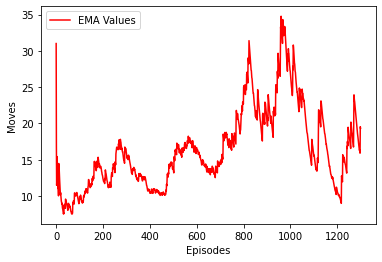

In [ ]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt

moves = N_moves_QLearning
# create a dataframe
nrMoves = pd.DataFrame({'moves': moves})
 
# finding EMA
ema = nrMoves.ewm(span=1000).mean()
 
plt.plot(ema, label="Q-Learning", color="red")
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.legend()
plt.show()

**SARSA**

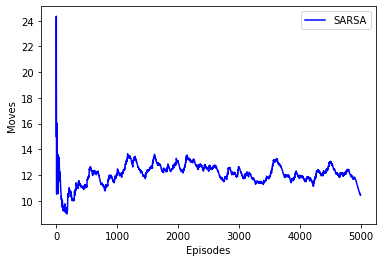

In [ ]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt

moves = N_moves_Sarsa
# create a dataframe
nrMoves = pd.DataFrame({'moves': moves})
 
# finding EMA
ema = nrMoves.ewm(span=1000).mean()
 
plt.plot(ema, label="SARSA", color="blue")
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.legend()
plt.show()

### Reward per game vs training time
**Q Learning**

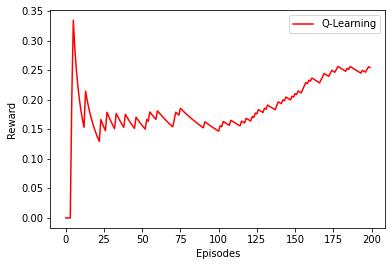

In [ ]:
rewards = R_QLearning[:200]
# create a dataframe
reward = pd.DataFrame({'rewards': rewards})
 
# finding EMA
ema = reward.ewm(span=1000).mean()
 
plt.plot(ema, label="Q-Learning", color="red")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()

**SARSA**

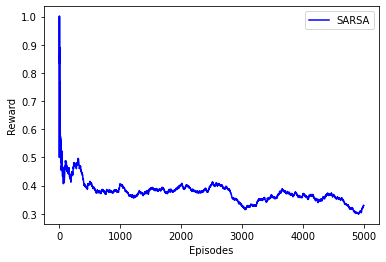

In [ ]:
rewards = R_Sarsa
# create a dataframe
reward = pd.DataFrame({'rewards': rewards})
 
# finding EMA
ema = reward.ewm(span=1000).mean()
 
plt.plot(ema, label="SARSA", color="blue")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()